In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (d_k ** 0.5)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        return output, attention_weights

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "ERROR"

        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, Q, K, V, mask=None):
        N = Q.size(0)

        Q = self.query(Q).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(K).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(V).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)

        attn_output, _ = ScaledDotProductAttention()(Q, K, V, mask)

        attn_output = attn_output.transpose(1, 2).contiguous().view(N, -1, self.num_heads * self.head_dim)
        output = self.fc_out(attn_output)
        return output

class PositionwiseFeedForward(nn.Module):
    def __init__(self, embed_dim, ff_dim):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, embed_dim)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = PositionwiseFeedForward(embed_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers, output_dim, seq_len, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_len, embed_dim))
        self.encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout)
        self.fc_out = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding
        x = self.encoder(x)

        output = self.fc_out(x)
        return output

if __name__ == "__main__":
    batch_size, seq_len, input_dim, output_dim = 32, 96, 8, 8
    embed_dim, num_heads, ff_dim, num_layers = 64, 8, 128, 4

    model = TimeSeriesTransformer(input_dim, embed_dim, num_heads, ff_dim, num_layers, output_dim, seq_len)
    x = torch.randn(batch_size, seq_len, input_dim)
    output = model(x)
    print(output.shape)  # Expected: [batch_size, seq_len, output_dim]


torch.Size([32, 96, 8])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (d_k ** 0.5)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        return output, attention_weights

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "ERROR"

        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, Q, K, V, mask=None):
        N = Q.size(0)

        Q = self.query(Q).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(K).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(V).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)

        attn_output, _ = ScaledDotProductAttention()(Q, K, V, mask)

        attn_output = attn_output.transpose(1, 2).contiguous().view(N, -1, self.num_heads * self.head_dim)
        output = self.fc_out(attn_output)
        return output

class PositionwiseFeedForward(nn.Module):
    def __init__(self, embed_dim, ff_dim):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, embed_dim)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

class iTransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = PositionwiseFeedForward(embed_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x

class iTransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            iTransformerEncoderLayer(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x

class iTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers, output_dim, seq_len, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(seq_len, embed_dim)  
        self.encoder = iTransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout)
        self.fc_out = nn.Linear(embed_dim, seq_len)  

    def forward(self, x):
        x = x.transpose(1, 2)  
        x = self.embedding(x) 
        x = self.encoder(x)  
        x = self.fc_out(x)  
        x = x.transpose(1, 2)  
        return x

if __name__ == "__main__":
    batch_size, seq_len, input_dim = 32, 96, 8
    embed_dim, num_heads, ff_dim, num_layers = 64, 8, 128, 4

    model = iTransformer(input_dim, embed_dim, num_heads, ff_dim, num_layers, input_dim, seq_len)
    x = torch.randn(batch_size, seq_len, input_dim)  
    output = model(x)
    print(output.shape)  

torch.Size([32, 96, 8])


(7588, 8)
Training Transformer model...
Epoch 1/10 | Train Loss (MSE): 0.0333 | Val MSE: 0.0181 | Val MAE: 0.1072
Epoch 2/10 | Train Loss (MSE): 0.0029 | Val MSE: 0.0081 | Val MAE: 0.0720
Epoch 3/10 | Train Loss (MSE): 0.0014 | Val MSE: 0.0015 | Val MAE: 0.0294
Epoch 4/10 | Train Loss (MSE): 0.0010 | Val MSE: 0.0021 | Val MAE: 0.0359
Epoch 5/10 | Train Loss (MSE): 0.0008 | Val MSE: 0.0014 | Val MAE: 0.0287
Epoch 6/10 | Train Loss (MSE): 0.0007 | Val MSE: 0.0017 | Val MAE: 0.0321
Epoch 7/10 | Train Loss (MSE): 0.0006 | Val MSE: 0.0014 | Val MAE: 0.0299
Epoch 8/10 | Train Loss (MSE): 0.0005 | Val MSE: 0.0013 | Val MAE: 0.0278
Epoch 9/10 | Train Loss (MSE): 0.0005 | Val MSE: 0.0015 | Val MAE: 0.0310
Epoch 10/10 | Train Loss (MSE): 0.0004 | Val MSE: 0.0015 | Val MAE: 0.0297

Final Test for Transformer -> MSE: 0.0017 | MAE: 0.0323

Training iTransformer model...
Epoch 1/10 | Train Loss (MSE): 0.0429 | Val MSE: 0.0029 | Val MAE: 0.0384
Epoch 2/10 | Train Loss (MSE): 0.0049 | Val MSE: 0.0017 

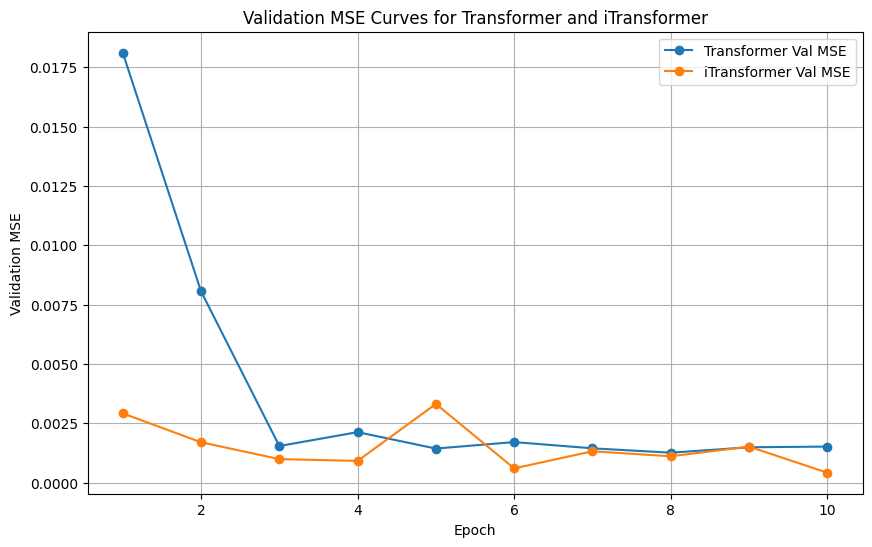

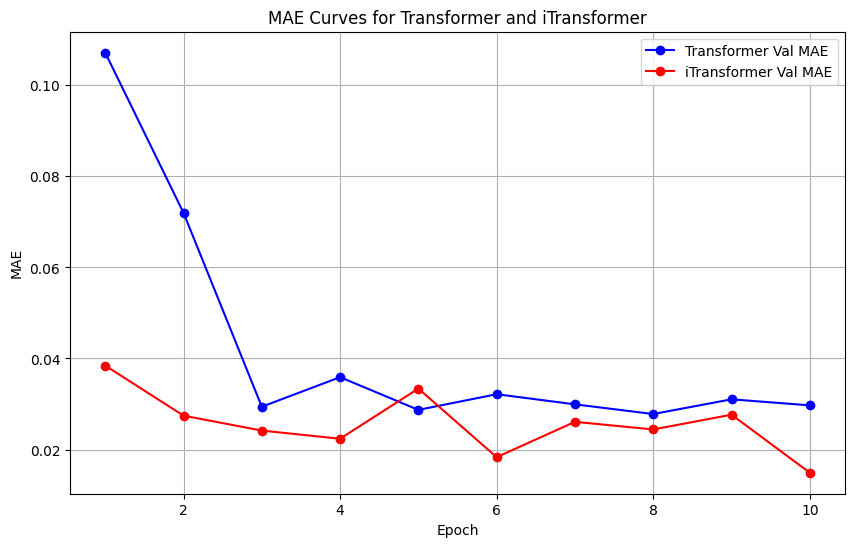

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt


# ===============================
# مدل Transformer برای پیش‌بینی نرخ ارز
# ===============================

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (d_k ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        return output, attention_weights

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by the number of heads"
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key   = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)
    
    def forward(self, Q, K, V, mask=None):
        N = Q.size(0)
        Q = self.query(Q).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(K).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(V).view(N, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        attn_output, _ = ScaledDotProductAttention()(Q, K, V, mask)
        attn_output = attn_output.transpose(1, 2).contiguous().view(N, -1, self.num_heads * self.head_dim)
        output = self.fc_out(attn_output)
        return output

class PositionwiseFeedForward(nn.Module):
    def __init__(self, embed_dim, ff_dim):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, ff_dim)
        self.fc2 = nn.Linear(ff_dim, embed_dim)
    
    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = PositionwiseFeedForward(embed_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        attn_output = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x
    

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)
        ])
    
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x

class TimeSeriesTransformer(nn.Module):
    """
    این مدل ورودی با شکل [batch, T, num_vars] می‌گیرد
    و پس از رمزگذاری، با میانگین‌گیری (pooling) یک نمایه کلی استخراج می‌کند.
    سپس با استفاده از یک MLP، پیش‌بینی S گام آینده برای هر متغیر انجام می‌شود.
    """
    def __init__(self, T, num_vars, embed_dim, num_heads, ff_dim, num_layers, S, dropout=0.1):
        super().__init__()
        self.T = T
        self.S = S
        self.num_vars = num_vars
        
        # لایه جاسازی: هر توکن مربوط به یک گام زمانی (با ابعاد num_vars) به فضای embed_dim نگاشت می‌شود.
        self.embedding = nn.Linear(num_vars, embed_dim)
        # Positional encoding به ابعاد [1, T, embed_dim]
        self.positional_encoding = nn.Parameter(torch.zeros(1, T, embed_dim))
        self.encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout)
        # pooling روی بعد زمان: به عنوان مثال میانگین‌گیری از تمام گام‌ها
        self.pool = nn.AdaptiveAvgPool1d(1)
        # سر پیش‌بینی: از نمایه کلی به S گام پیش‌بینی برای هر متغیر
        self.fc_out = nn.Linear(embed_dim, S * num_vars)
    
    def forward(self, x):
        # x: [batch, T, num_vars]
        x = self.embedding(x) + self.positional_encoding  # [batch, T, embed_dim]
        x = self.encoder(x)  # [batch, T, embed_dim]
        # pooling روی بعد زمان: تغییر شکل به [batch, embed_dim, T] سپس میانگین‌گیری -> [batch, embed_dim, 1]
        x = self.pool(x.transpose(1, 2)).squeeze(-1)  # [batch, embed_dim]
        out = self.fc_out(x)  # [batch, S * num_vars]
        out = out.view(-1, self.S, self.num_vars)  # [batch, S, num_vars]
        return out

# ===============================
# مدل iTransformer برای پیش‌بینی نرخ ارز
# ===============================

class iTransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = PositionwiseFeedForward(embed_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        attn_output = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class iTransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            iTransformerEncoderLayer(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)
        ])
    
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x

class iTransformer(nn.Module):
    """
    در iTransformer، کل سری زمانی هر متغیر به عنوان یک توکن در نظر گرفته می‌شود.
    ورودی ابتدا به شکل [batch, T, num_vars] است، سپس به [batch, num_vars, T] تغییر شکل می‌یابد.
    سپس هر سری زمانی به فضای embed_dim جاسازی شده و از طریق رمزگذار پردازش می‌شود.
    در نهایت، هر توکن (متغیر) از طریق یک MLP به S گام پیش‌بینی نگاشت می‌شود.
    """
    def __init__(self, T, num_vars, embed_dim, num_heads, ff_dim, num_layers, S, dropout=0.1):
        super().__init__()
        self.T = T
        self.S = S
        self.num_vars = num_vars
        
        # جاسازی: هر سری زمانی (طول T) به فضای embed_dim نگاشت می‌شود.
        self.embedding = nn.Linear(T, embed_dim)
        self.encoder = iTransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout)
        # سر پیش‌بینی: هر توکن (متغیر) به S گام پیش‌بینی نگاشت می‌شود.
        self.fc_out = nn.Linear(embed_dim, S)
    
    def forward(self, x):
        # x: [batch, T, num_vars]، تغییر شکل به [batch, num_vars, T]
        x = x.transpose(1, 2)  # حالا: [batch, num_vars, T]
        x = self.embedding(x)  # [batch, num_vars, embed_dim]
        x = self.encoder(x)    # [batch, num_vars, embed_dim]
        out = self.fc_out(x)   # [batch, num_vars, S]
        out = out.transpose(1, 2)  # [batch, S, num_vars]
        return out

# ===============================
# تعریف دیتاست و آماده‌سازی داده‌ها
# ===============================

class ExchangeRateDataset(Dataset):
    def __init__(self, data, T, S):
        """
        data: آرایه numpy با شکل [total_time, num_vars]
        T: طول دوره نگاه (lookback)
        S: طول دوره پیش‌بینی (forecast horizon)
        """
        self.data = data
        self.T = T
        self.S = S
        self.samples = []
        # ایجاد نمونه‌ها با استفاده از پنجره لغزان
        for i in range(len(data) - T - S + 1):
            x = data[i : i+T]        # داده‌های گذشته
            y = data[i+T : i+T+S]      # داده‌های آینده
            self.samples.append((x, y))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        x, y = self.samples[idx]
        # تبدیل به Tensor
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# def generate_synthetic_data(total_time=2000, num_vars=8, seed=42):
#     random.seed(seed)
#     np.random.seed(seed)
#     # تولید داده‌های مصنوعی به عنوان شبیه‌سازی نرخ ارز
#     data = np.cumsum(np.random.randn(total_time, num_vars), axis=0)
#     return data

# ===============================
# توابع آموزش و ارزیابی
# ===============================

def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)  # خروجی: [batch, S, num_vars]
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    return running_loss / len(dataloader.dataset)

def evaluate_model(model, dataloader, criterion_mse, criterion_mae, device):
    model.eval()
    total_mse = 0.0
    total_mae = 0.0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss_mse = criterion_mse(output, y)
            loss_mae = criterion_mae(output, y)
            total_mse += loss_mse.item() * x.size(0)
            total_mae += loss_mae.item() * x.size(0)
    avg_mse = total_mse / len(dataloader.dataset)
    avg_mae = total_mae / len(dataloader.dataset)
    return avg_mse, avg_mae

# ===============================
# بخش اصلی: آموزش مدل‌ها و گزارش نتایج
# ===============================

def main():
    # پارامترهای اصلی
    T = 96      # طول دوره نگاه
    S = 12      # طول دوره پیش‌بینی
    num_vars = 8
    embed_dim = 64
    num_heads = 8
    ff_dim = 128
    num_layers = 4
    batch_size = 32
    epochs = 10
    learning_rate = 1e-3

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    file_path = "exchange_rate.csv"  # مسیر فایل دیتاست واقعی خود را قرار دهید
    df = pd.read_csv(file_path, index_col=0)
    data = df.values  # data.shape باید به شکل [total_time, num_vars] باشد

    print(df.shape)    

    # تقسیم داده‌ها به آموزش، اعتبارسنجی و تست (به عنوان مثال 70%, 15%, 15%)
    total_samples = len(data)
    train_data = data[:int(0.7 * total_samples)]
    val_data = data[int(0.7 * total_samples): int(0.85 * total_samples)]
    test_data = data[int(0.85 * total_samples):]
    
    train_dataset = ExchangeRateDataset(train_data, T, S)
    val_dataset = ExchangeRateDataset(val_data, T, S)
    test_dataset = ExchangeRateDataset(test_data, T, S)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # تعریف معیارها
    criterion_mse = nn.MSELoss()
    criterion_mae = nn.L1Loss()    
    
    # ===============================
    # آموزش مدل Transformer
    # ===============================

    transformer_model = TimeSeriesTransformer(T, num_vars, embed_dim, num_heads, ff_dim, num_layers, S).to(device)
    optimizer_trans = torch.optim.Adam(transformer_model.parameters(), lr=learning_rate)

    transformer_val_mse = []
    transformer_val_mae = []
    print("Training Transformer model...")
    for epoch in range(epochs):
        train_loss = train_model(transformer_model, train_loader, optimizer_trans, criterion_mse, device)
        val_mse, val_mae = evaluate_model(transformer_model, val_loader, criterion_mse, criterion_mae, device)
        transformer_val_mse.append(val_mse)
        transformer_val_mae.append(val_mae)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss (MSE): {train_loss:.4f} | Val MSE: {val_mse:.4f} | Val MAE: {val_mae:.4f}")
    
    test_mse_trans, test_mae_trans = evaluate_model(transformer_model, test_loader, criterion_mse, criterion_mae, device)
    print(f"\nFinal Test for Transformer -> MSE: {test_mse_trans:.4f} | MAE: {test_mae_trans:.4f}")
    
    # ===============================
    # آموزش مدل iTransformer
    # ===============================

    itransformer_model = iTransformer(T, num_vars, embed_dim, num_heads, ff_dim, num_layers, S).to(device)
    optimizer_itrans = torch.optim.Adam(itransformer_model.parameters(), lr=learning_rate)
    
    itransformer_val_mse = []
    itransformer_val_mae = []
    print("\nTraining iTransformer model...")
    for epoch in range(epochs):
        train_loss = train_model(itransformer_model, train_loader, optimizer_itrans, criterion_mse, device)
        val_mse, val_mae = evaluate_model(itransformer_model, val_loader, criterion_mse, criterion_mae, device)
        itransformer_val_mse.append(val_mse)
        itransformer_val_mae.append(val_mae)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss (MSE): {train_loss:.4f} | Val MSE: {val_mse:.4f} | Val MAE: {val_mae:.4f}")
    
    test_mse_itrans, test_mae_itrans = evaluate_model(itransformer_model, test_loader, criterion_mse, criterion_mae, device)
    print(f"\nFinal Test for iTransformer -> MSE: {test_mse_itrans:.4f} | MAE: {test_mae_itrans:.4f}")

    # ===============================
    # رسم نمودار مقایسه‌ای MSE (مجموعه اعتبارسنجی) برای هر دو مدل
    # ===============================

    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, transformer_val_mse, label="Transformer Val MSE", marker='o')
    plt.plot(epochs_range, itransformer_val_mse, label="iTransformer Val MSE", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Validation MSE")
    plt.title("Validation MSE Curves for Transformer and iTransformer")
    plt.legend()
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, transformer_val_mae, 'b-o', label='Transformer Val MAE')
    plt.plot(epochs_range, itransformer_val_mae, 'r-o', label='iTransformer Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('MAE Curves for Transformer and iTransformer')
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    main()
